# EECE7150 AFR, Homework 3

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from Homography import Homography
from Mosaic import Mosaic
from Features import Features

%load_ext autoreload
%autoreload 2

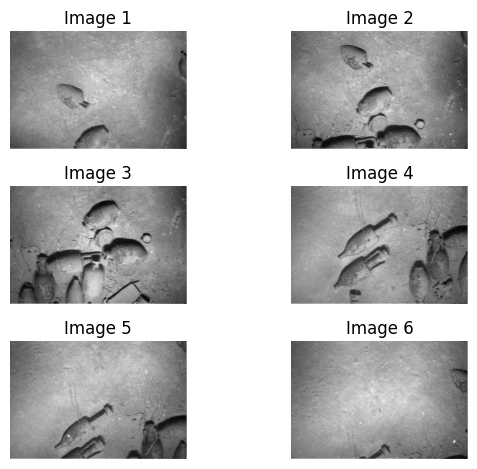

In [2]:
mosaic = Mosaic()
mosaic.read_imgs_from_folder("6Images/", resize_factor = 1, show_imgs = True)

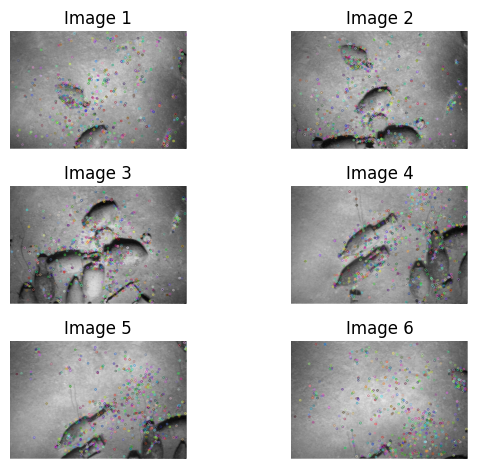

In [3]:
features = Features()
features.create_sift()
keypoints_list, descriptor_list = features.detect_keypoints(mosaic.mosaic_imgs_gray,
                                                            mosaic.num_imgs_mosaic,
                                                            True)

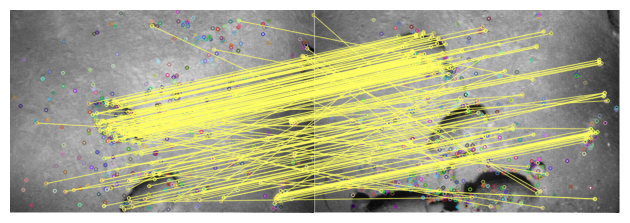

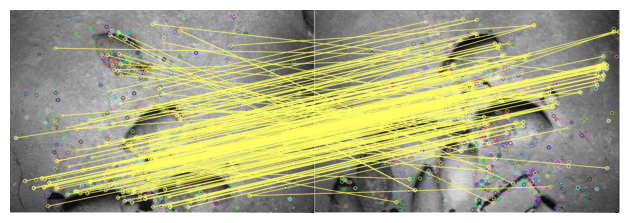

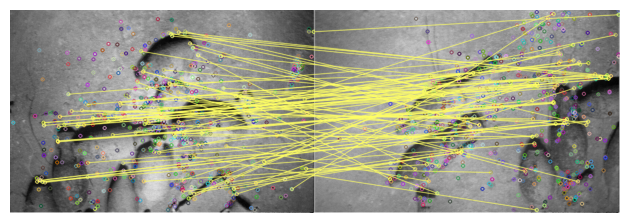

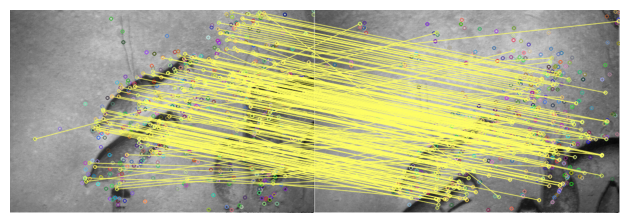

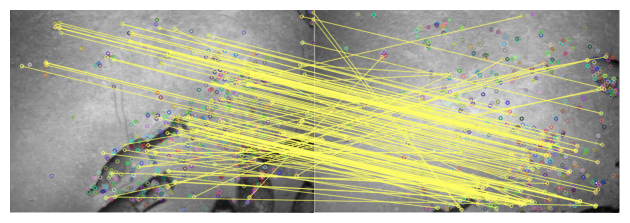

In [4]:
homography = Homography()
homographies_temporal = [np.identity(3)]
for i in range(mosaic.num_imgs_mosaic-1):
    x, x_dash = features.match_features(mosaic.mosaic_imgs_gray[i], 
                                        mosaic.mosaic_imgs_gray[i+1],
                                        keypoints_list[i],
                                        keypoints_list[i+1],
                                        descriptor_list[i],
                                        descriptor_list[i+1])
    
    homography.num_points = len(x)
    H = homography.calculate_homography(x, x_dash)
    homographies_temporal.append(np.linalg.inv(H))
    homographies_temporal[i+1] @= homographies_temporal[i]

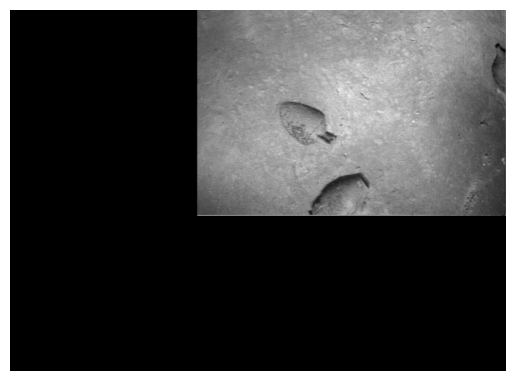

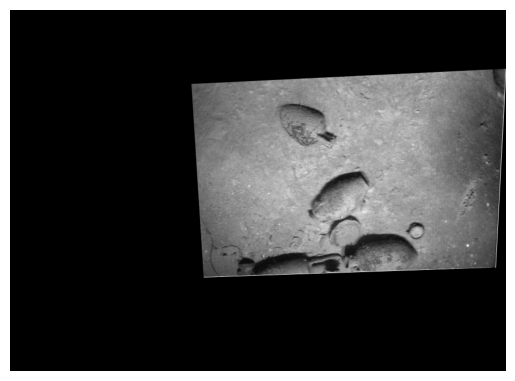

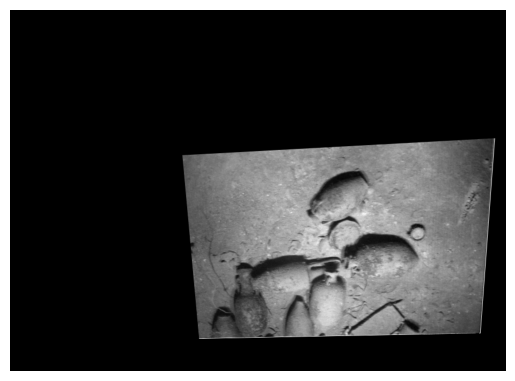

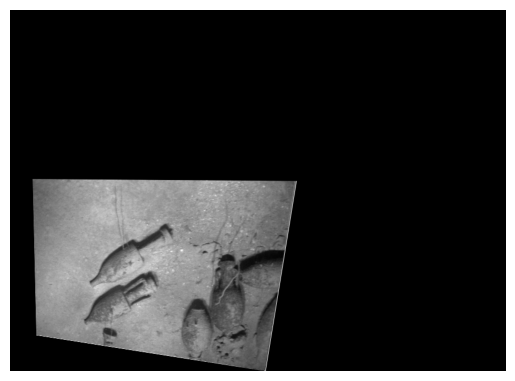

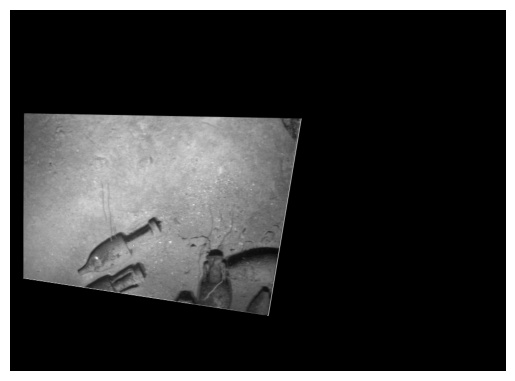

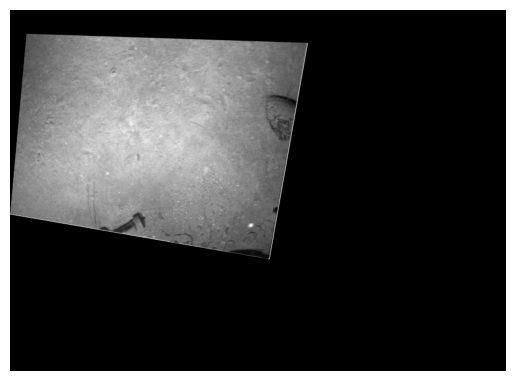

In [5]:
min_x, min_y, max_x, max_y = mosaic.calculate_min_max_coordinates(homographies_temporal)
warped_images = mosaic.warp_images(homographies_temporal, min_x, min_y, max_x, max_y)

for i in range(mosaic.num_imgs_mosaic):
    plt.figure()
    plt.imshow(warped_images[i], cmap="gray")
    plt.axis("off")

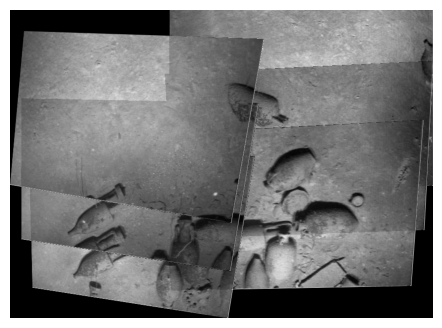

In [6]:
panorama = np.zeros_like(warped_images[0])
canvas_mask = np.copy(panorama)
alpha = 0.2

plt.figure(figsize=(12, 4))

for i in range(len(warped_images)):
    transformed_corners = mosaic.transform_img_corners(homographies_temporal[i])
    warp_mask = np.zeros_like(warped_images[0])
    cv2.fillPoly(warp_mask, [transformed_corners.astype(int)], (255, 255, 255))

    overlap_mask = cv2.bitwise_and(warp_mask, canvas_mask)
    not_overlap_mask = cv2.bitwise_not(overlap_mask)
    overlap_idx = np.where(overlap_mask>0)
    
    panorama = cv2.bitwise_or(panorama, warped_images[i], mask=not_overlap_mask[:,:,0])
    panorama[overlap_idx] = (alpha)*panorama[overlap_idx] + (1-alpha)*warped_images[i][overlap_idx]
    canvas_mask = cv2.bitwise_or(canvas_mask, warp_mask)

plt.imshow(panorama)
plt.axis('off')
plt.show()